# Linear Regression: Understanding, Diagnostics, and Common Pitfalls

Linear regression is often the first machine learning model you learn.  
Despite its simplicity, it is **frequently misused**. This notebook will teach you:

- The mathematical foundations of linear regression  
- How predictions are made  
- How to check assumptions and residuals  
- How to handle common issues like multicollinearity and heteroscedasticity  
- How to evaluate model performance

We will use the **California Housing dataset** to illustrate all steps.


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# Load dataset
data = fetch_california_housing(as_frame=True)
df = data.frame

# Features and target
X = df.drop(columns="MedHouseVal")
y = df["MedHouseVal"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Display first rows
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## 1. Linear Regression: Mathematical View

### Design Matrix X

$$
X =
\begin{bmatrix}
1 & 8.3252 & 41.0 & 6.9841 & 1.0238 & 322.0 & 2.5556 & 37.88 & -122.23 \\
1 & 8.3014 & 21.0 & 6.2381 & 0.9719 & 2401.0 & 2.1098 & 37.86 & -122.22
\end{bmatrix}
$$

Each row represents **one observation (house)**.  
Each column represents **one feature**.

---

### Parameter Vector β

$$
\beta =
\begin{bmatrix}
\beta_0 \\
\beta_1 \\
\beta_2 \\
\beta_3 \\
\beta_4 \\
\beta_5 \\
\beta_6 \\
\beta_7 \\
\beta_8
\end{bmatrix}
$$

- $\beta_0$ is the intercept  
- Each $\beta_j$ measures the contribution of one feature

---

### Target Vector y

$$
y =
\begin{bmatrix}
4.526 \\
3.585
\end{bmatrix}
$$

---

### Model Prediction

Linear regression predicts house values via matrix multiplication:

$$
\hat{y} = X\beta
$$

Which expands to:

$$
\hat{y}_i = \beta_0 +
\beta_1 \cdot \text{MedInc}_i +
\beta_2 \cdot \text{HouseAge}_i +
\cdots +
\beta_8 \cdot \text{Longitude}_i
$$



For observation $i$, the residual is defined as:

$$
e_i = y_i - \hat{y}_i
$$

Linear regression estimates $\beta$ by minimizing the **Residual Sum of Squares (RSS)**:

$$
RSS = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

$$
RSS(\beta) = \sum_{i=1}^{n} (y_i - x_i^T \beta)^2
$$

In [2]:
# Fit linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Residuals
residuals = pd.Series(y_test - y_pred, index=y_test.index)

**model.fit(X_train, y_train)**
This is the key step.

The algorithm solves Ordinary Least Square(OLS) by default:

$$
\hat{\beta} = \arg\min_{\beta} \sum_{i=1}^{n}
(y_i - x_i^T \beta)^2
$$
After this line:
- β is **decided**
- RSS is **minimized on training data**
- The model is fully specified

--- 
## How does the algorithm actually find $\hat{\beta}$?

There are two main ways:

### 4a. Ordinary Least Square(OLS) BY DEFAULT

$$
\hat{\beta} = (X^T X)^{-1} X^T y
$$

- $X$ = your matrix of features, one row per observation, one column per feature (plus intercept column of ones)  
- $y$ = vector of target values  

This directly solves the minimization of RSS. Recall calculations from linear algebra. 

---

### 4b. Iterative Optimization (Gradient Descent) 

1. Start with some guess of $\beta$  
2. Compute the gradient of RSS with respect to $\beta$  
3. Take small steps “downhill” in the direction that reduces RSS  
4. Repeat until convergence  

This method also finds $\hat{\beta}$, the value that minimizes RSS. We will stop on this later. 

## 2. Residual Diagnostics

Well-specified linear regression residuals should:

- Scatter randomly around 0  
- Have constant variance (homoscedasticity)  
- Show no extreme outliers  
- Be approximately normally distributed

Let's visualize residuals against predictions.


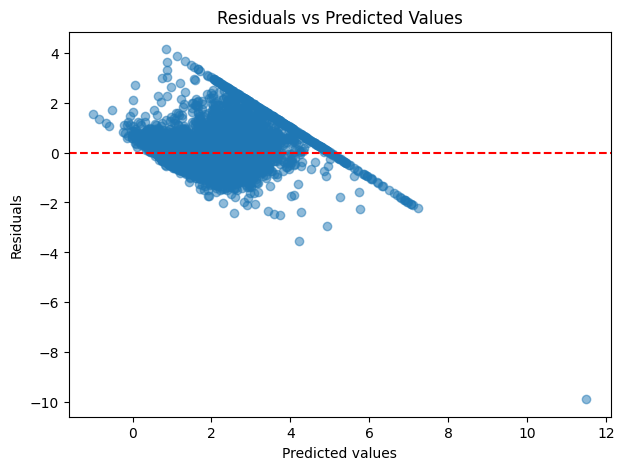

In [3]:
plt.figure(figsize=(7,5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, linestyle="--", color='red')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()


### Interpretation:

- **Downward-sloping trend** → maybe nonlinearity  
- **Wedge/funnel shape** → heteroscedasticity  
- **Outliers** → influential points  
- **Skewed around zero** → normality violation

We will now check these issues systematically.


### 2.1 Residuals vs Features (Linearity Check)

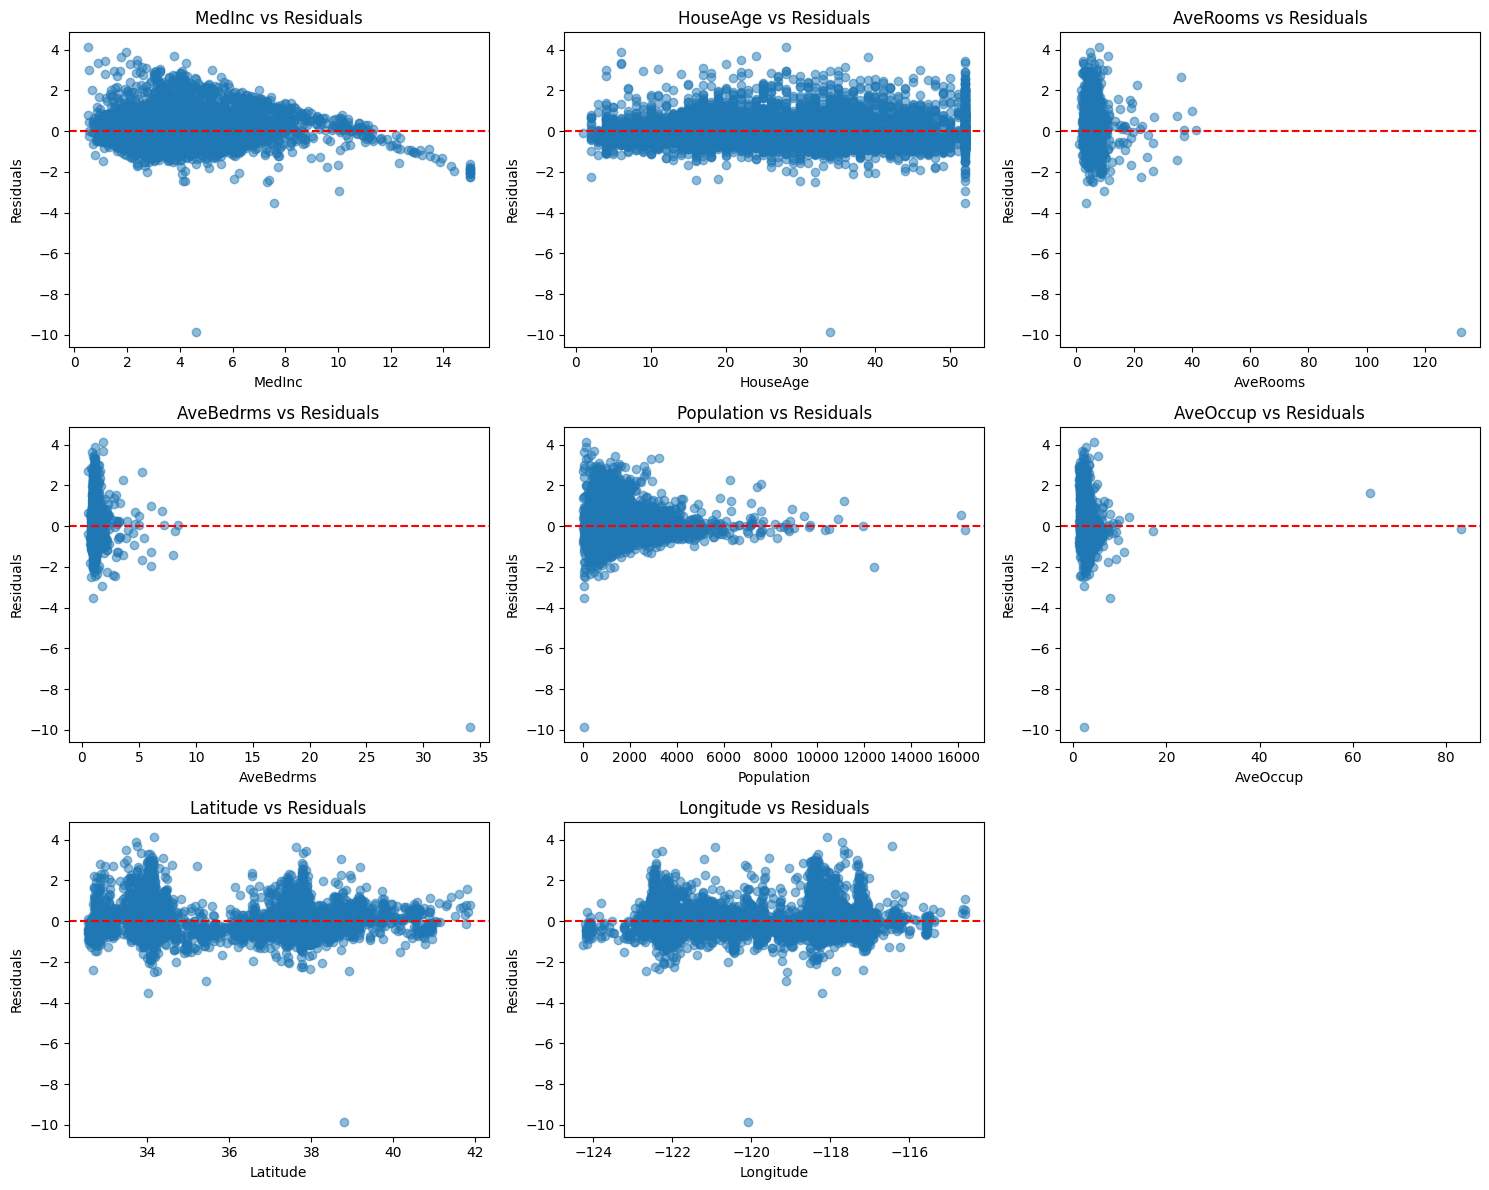

In [4]:
features = X.columns
n_features = len(features)
n_cols = 3
n_rows = int(np.ceil(n_features / n_cols))

plt.figure(figsize=(15, 4 * n_rows))
for i, feature in enumerate(features):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    ax.scatter(X_test[feature], residuals, alpha=0.5)
    ax.axhline(0, color='red', linestyle='--')
    ax.set_xlabel(feature)
    ax.set_ylabel("Residuals")
    ax.set_title(f"{feature} vs Residuals")
plt.tight_layout()
plt.show()

### Observations

| Feature | Residual Pattern | Linearity Assumption | Recommended Action |
|---------|----------------|--------------------|------------------|
| MedInc | Clear downward trend | ❌ Violated | Add nonlinear terms, log transform, or interactions |
| HouseAge | Random scatter | ✅ Satisfied | No change needed |
| AveRooms | Clustering, skew | ❌ Violated | Transform or cap outliers |
| AveBedrms | Skewed, nonlinear | ❌ Violated | Transform or remove |
| Population | Funnel shape | ⚠️ Partially | Transform or robust regression |
| AveOccup | Skewed, outliers | ❌ Violated | Transform or winsorize |
| Latitude | Wave-like pattern | ❌ Violated | Include spatial interactions |
| Longitude | Structured bands | ❌ Violated | Include spatial interactions |


### 2.2 Normality of Residuals

<Figure size 600x400 with 0 Axes>

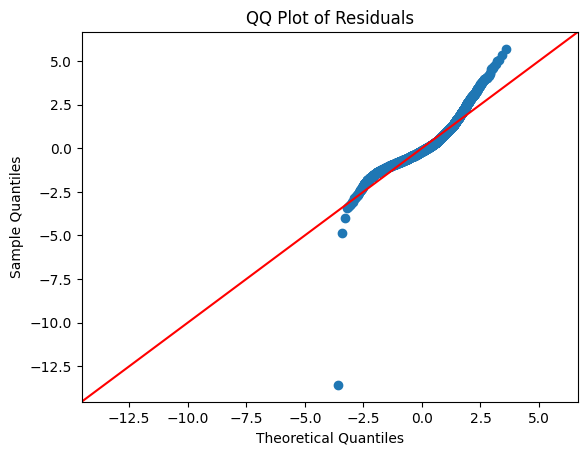

In [5]:
import statsmodels.api as sm

plt.figure(figsize=(6,4))
sm.qqplot(residuals, line='45', fit=True)
plt.title("QQ Plot of Residuals")
plt.show()


Residuals are **not perfectly normal**, showing heavy tails and asymmetry → violation of normality assumption.

### 2.3 Outliers and Influence – Cook’s Distance

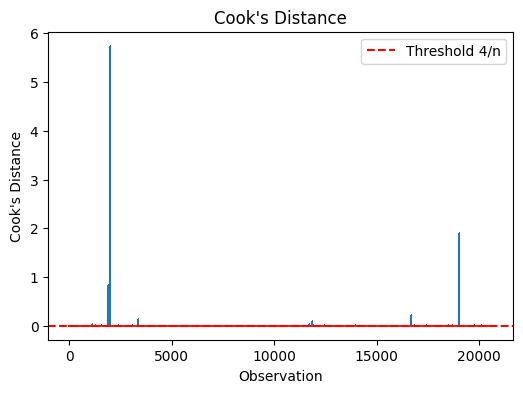

Number of potentially influential points: 939


In [6]:
X_sm = sm.add_constant(X)
ols_model = sm.OLS(y, X_sm).fit()
influence = ols_model.get_influence()
cooks = influence.cooks_distance[0]

plt.figure(figsize=(6,4))
plt.stem(np.arange(len(cooks)), cooks, markerfmt=",")
plt.axhline(4/len(cooks), color='red', linestyle='--', label='Threshold 4/n')
plt.xlabel("Observation")
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance")
plt.legend()
plt.show()

influential_idx = np.where(cooks > 4/len(cooks))[0]
print(f"Number of potentially influential points: {len(influential_idx)}")


**Result:** A large number of observations exceed the Cook’s distance threshold (939 points), indicating widespread influence rather than isolated outliers. This suggests model misspecification due to nonlinear spatial effects, heteroscedasticity, and a capped target variable, rather than data errors. Removing these points is inappropriate; instead, the model should be reformulated to better capture the underlying data-generating process.

In practive, we can remove some points above some Cook's distance treshold. 

### 2.4 Multicollinearity – Variance Inflation Factor (VIF)
**Assumption:** Columns of $(X)$ are not perfectly correlated.

**VIF formula:**

$$
\text{VIF}_j = \frac{1}{1 - R_j^2}, \quad j=1,\dots,p
$$

- $(R_j^2)$ is obtained by regressing $(X_j)$ on all other predictors.  
- Rule of thumb: VIF > 5–10 indicates multicollinearity.

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data["VIF"] = np.round(vif_data["VIF"], 2)
vif_data

,feature,VIF
0,MedInc,11.51
1,HouseAge,7.20
2,AveRooms,45.99
3,AveBedrms,43.59
4,Population,2.94
5,AveOccup,1.10
6,Latitude,559.87
7,Longitude,633.71


## Result of the VIF

- **AveRooms** & **AveBedrms** are almost perfectly correlated → one of them should be removed or combined.
- **Latitude** & **Longitude** are extremely correlated → consider spatial transformation (e.g., clustering or distance-based encoding).
- **MedInc** is correlated with other features → check if all features are necessary.

**Consequences:**

- OLS coefficients for high-VIF features are unstable
- Standard errors are inflated
- Significance tests (p-values) may be misleading

## Next Steps / Remedies

- Remove or combine highly correlated features  
  *Example:* `AveRooms / AveBedrms → AveRoomPerBedroom`
- Apply **PCA** or **PLS** to reduce dimensionality and multicollinearity
- For spatial features, consider **spatial encoding** instead of raw latitude/longitude
- Use regularization (**Ridge** or **Lasso**) to stabilize coefficients


In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# Step 1: Combine AveRooms and AveBedrms
X_new = X.copy()
X_new['RoomsPerBedroom'] = X_new['AveRooms'] / X_new['AveBedrms']
X_new = X_new.drop(columns=['AveRooms', 'AveBedrms'])

# Step 2: Create a spatial feature: DistanceToCenter
# Using mean latitude/longitude as center
lat_center = X_new['Latitude'].mean()
lon_center = X_new['Longitude'].mean()
X_new['DistanceToCenter'] = np.sqrt((X_new['Latitude'] - lat_center)**2 +
                                    (X_new['Longitude'] - lon_center)**2)
X_new = X_new.drop(columns=['Latitude', 'Longitude'])

# Step 3: Standardize features (optional, for VIF stability)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_new), columns=X_new.columns)

# Step 4: Recalculate VIFs
vif_data = pd.DataFrame()
vif_data["feature"] = X_scaled.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]
vif_data["VIF"] = np.round(vif_data["VIF"], 2)
vif_data


,feature,VIF
0,MedInc,2.46
1,HouseAge,1.14
2,Population,1.12
3,AveOccup,1.01
4,RoomsPerBedroom,2.50
5,DistanceToCenter,1.02


In [9]:
X_train_new, X_test_new, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

model = LinearRegression()
model.fit(X_train_new, y_train)
y_pred_new = model.predict(X_test_new)

### 4. Model Evaluation Metrics

- **TSS**: Total sum of squares  
- **RSS**: Residual sum of squares  
- **ESS**: Explained sum of squares  

\[
TSS = ESS + RSS
\]


## Error metrics: 

### R²
$$
R^2 = 1 - \frac{RSS}{TSS}
$$

### Mean Squared Error (MSE)

$$
MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

- Penalizes large errors strongly
- Sensitive to outliers

### Mean Absolute Error (MAE)

$$
MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$

### 5. Adjusted R², AIC, BIC

R² increases with more features → may overfit  
Adjusted R² penalizes unnecessary features  

### Adjusted R²

$$
\text{Adjusted } R^2 = 1 - (1 - R^2)\frac{n - 1}{n - p - 1}
$$

where:

- $n$ is the number of observations
- $p$ is the number of features

### Akaike Information Criterion (AIC)

$$
AIC = n \ln\left(\frac{RSS}{n}\right) + 2p
$$

### Bayesian Information Criterion (BIC)

$$
BIC = n \ln\left(\frac{RSS}{n}\right) + p \ln(n)
$$

### Mallows' Cp

$$
C_p = \frac{RSS_p}{\hat{\sigma}^2} - (n - 2p)
$$


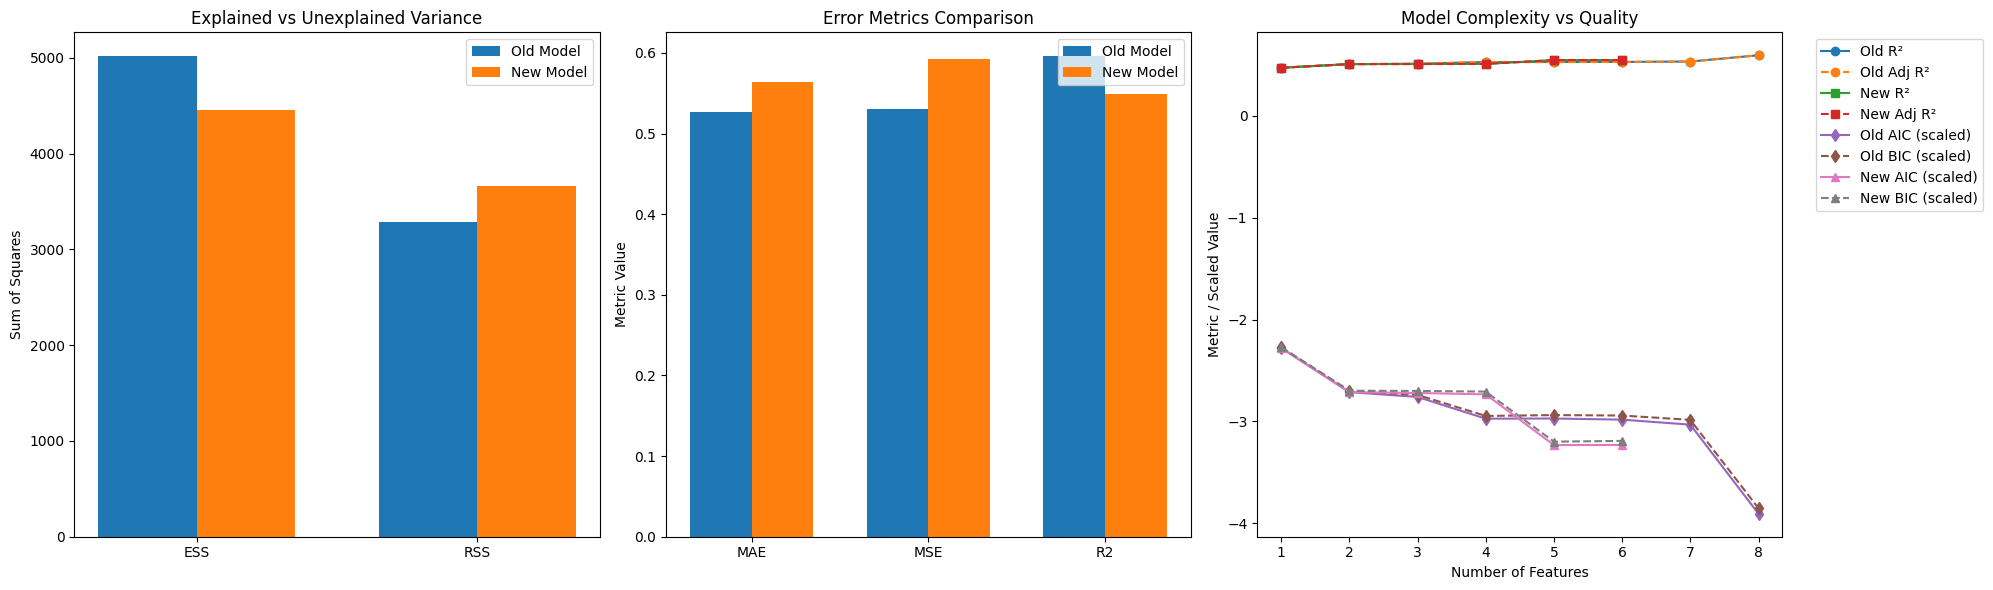

In [12]:
# --- Compute ESS/RSS ---
y_mean = y_test.mean()
RSS_old = np.sum((y_test - y_pred) ** 2)
ESS_old = np.sum((y_pred - y_mean) ** 2)

RSS_new = np.sum((y_test - y_pred_new) ** 2)
ESS_new = np.sum((y_pred_new - y_mean) ** 2)

# --- Compute Error Metrics ---
errors_old = {
    "MAE": mean_absolute_error(y_test, y_pred),
    "MSE": mean_squared_error(y_test, y_pred),
    "R2": r2_score(y_test, y_pred)
}
errors_new = {
    "MAE": mean_absolute_error(y_test, y_pred_new),
    "MSE": mean_squared_error(y_test, y_pred_new),
    "R2": r2_score(y_test, y_pred_new)
}

# --- Compute Model Complexity Metrics for old and new models ---
def compute_metrics(X, y):
    metrics = []
    n_features_total = X.shape[1]
    for k in range(1, n_features_total + 1):
        X_sub = X.iloc[:, :k]
        Xtr, Xte, ytr, yte = train_test_split(X_sub, y, test_size=0.3, random_state=42)
        model = LinearRegression().fit(Xtr, ytr)
        yhat = model.predict(Xte)
        rss = np.sum((yte - yhat) ** 2)
        n = len(yte)
        metrics.append({
            "features": k,
            "R2": r2_score(yte, yhat),
            "Adj_R2": 1 - (1 - r2_score(yte, yhat)) * (n - 1) / (n - k - 1),
            "AIC": n * np.log(rss / n) + 2 * k,
            "BIC": n * np.log(rss / n) + k * np.log(n)
        })
    return pd.DataFrame(metrics)

metrics_old = compute_metrics(X, y)  # X_old = features of old model
metrics_new = compute_metrics(X_new, y)  # X_new = features of new (VIF-reduced) model

# --- Create dashboard figure ---
fig, axes = plt.subplots(1, 3, figsize=(20,6))

# 1️⃣ ESS vs RSS
bar_width = 0.35
x1 = [0, 1]
axes[0].bar([i - bar_width/2 for i in x1], [ESS_old, RSS_old], width=bar_width, label="Old Model")
axes[0].bar([i + bar_width/2 for i in x1], [ESS_new, RSS_new], width=bar_width, label="New Model")
axes[0].set_xticks(x1)
axes[0].set_xticklabels(["ESS", "RSS"])
axes[0].set_ylabel("Sum of Squares")
axes[0].set_title("Explained vs Unexplained Variance")
axes[0].legend()

# 2️⃣ Error Metrics
x2 = range(len(errors_old))
axes[1].bar([i - bar_width/2 for i in x2], list(errors_old.values()), width=bar_width, label="Old Model")
axes[1].bar([i + bar_width/2 for i in x2], list(errors_new.values()), width=bar_width, label="New Model")
axes[1].set_xticks(x2)
axes[1].set_xticklabels(list(errors_old.keys()))
axes[1].set_ylabel("Metric Value")
axes[1].set_title("Error Metrics Comparison")
axes[1].legend()

# 3️⃣ Model Complexity Metrics
axes[2].plot(metrics_old["features"], metrics_old["R2"], 'o-', label="Old R²")
axes[2].plot(metrics_old["features"], metrics_old["Adj_R2"], 'o--', label="Old Adj R²")
axes[2].plot(metrics_new["features"], metrics_new["R2"], 's-', label="New R²")
axes[2].plot(metrics_new["features"], metrics_new["Adj_R2"], 's--', label="New Adj R²")
# Scaled AIC/BIC
axes[2].plot(metrics_old["features"], metrics_old["AIC"]/1000, 'd-', label="Old AIC (scaled)")
axes[2].plot(metrics_old["features"], metrics_old["BIC"]/1000, 'd--', label="Old BIC (scaled)")
axes[2].plot(metrics_new["features"], metrics_new["AIC"]/1000, '^-', label="New AIC (scaled)")
axes[2].plot(metrics_new["features"], metrics_new["BIC"]/1000, '^--', label="New BIC (scaled)")

axes[2].set_xlabel("Number of Features")
axes[2].set_ylabel("Metric / Scaled Value")
axes[2].set_title("Model Complexity vs Quality")
axes[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

**Result:** Reducing multicollinearity does not always improve predictive performance, but it makes the model more robust, interpretable, and suitable for inference. Linear regression assumptions and misspecification still limit accuracy, so further feature engineering, transformations, or alternative models are needed.

# Advanced Linear Regression Considerations

After examining residuals, the next step is **refining the model** and checking that assumptions hold. This ensures your model is **reliable, interpretable, and generalizable**.

---

## 1️⃣ Subset Selection / Feature Selection

In practice, not all features are equally useful. Subset selection helps you choose the best combination of predictors.

### Common approaches:

1. **Stepwise Selection**
   - **Forward Selection:** start with no variables, add the most significant one at each step
   - **Backward Elimination:** start with all variables, remove the least significant one at each step
   - **Bidirectional / Stepwise:** combine forward + backward

2. **Other techniques**
   - **Regularization:** Lasso (L1), Ridge (L2)
   - **Information criteria:** AIC, BIC
   - **Cross-validation** to select features that improve generalization

> Goal: simplify the model while maintaining predictive power.

---

## 2️⃣ Linear Regression Assumptions

Linear regression relies on several key assumptions. Violations can bias results or inflate errors.

| Assumption | What to check | Diagnostic / Method |
|------------|---------------|------------------|
| **Linearity** | Relationship between features and target is linear | Residuals vs predicted plot; component + residual plots |
| **Homoscedasticity** | Constant variance of errors | Residuals vs predicted; Breusch-Pagan test |
| **Independence** | Errors are independent | Check study design; Durbin-Watson test (time series) |
| **Normality of errors** | Errors are approximately normally distributed | QQ plot; Shapiro-Wilk test |

---

## 3️⃣ Common Pitfalls & Remedies

1. **Heteroscedasticity**
   - Problem: variance of residuals increases/decreases with fitted values
   - Remedy: transform target variable (log, sqrt), weighted regression

2. **Outliers / Influential points**
   - Check with **Cook’s Distance** or leverage statistics  
   - Remove or investigate extreme points

3. **Multicollinearity**
   - Highly correlated predictors inflate coefficient variance
   - Check **Variance Inflation Factor (VIF)**  
   - Remedies: PCA, PLS, or remove correlated predictors

4. **Confounding Variables**
   - Variables that affect both predictors and target can bias coefficients
   - Remedies:
     - Include confounders in the model
     - Use stratification or matching
     - Be aware of omitted variable bias

---

## 4️⃣ Testing Confounding & Bias

- For categorical confounders, **Chi-square tests** can check associations between predictor and outcome  
- Consider stratifying the analysis by confounder categories  
- Always evaluate if omitted variables could bias estimates

---
